# 1. Imports

In [1]:
import os
import numpy as np
import cv2
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential , Model, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras import optimizers

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# Check running on GPU

len(tf.config.experimental.list_physical_devices("GPU")) 

1

# 2. Exploratory Data Analysis

## 2.1. Number of Images

In [3]:
fake_path = 'data/fake/images/'
mask_path = 'data/fake/masks/'
original_path = 'data/original/'

In [4]:
print('Number of fake images = {}'.format((len(os.listdir(fake_path))))) # the folder contains both fake image and its mask
print('Number of pristine images = {}'.format((len(os.listdir(original_path)))))

Number of fake images = 3204
Number of pristine images = 3204



## 2.2. Fake Images Shape

In [5]:
fakes = os.listdir(fake_path)

In [6]:
fake_shapes=[]

for fake in fakes:
    img = Image.open(fake_path+fake)
    img_array = np.array(img)
    fake_shapes.append(img_array.shape)

In [7]:
for i in range(20):
    ind=np.random.randint(0, len(fake_shapes))
    print(str(ind) +'\t\t'+ str(fake_shapes[ind]) +'\t\t'+fakes[ind])

1001		(640, 427, 3)		0_000000095380.jpg
117		(333, 500, 3)		0_000000011702.jpg
3200		(640, 480, 3)		0_000000296492.jpg
776		(480, 640, 3)		0_000000074407.jpg
578		(497, 640, 3)		0_000000056119.jpg
514		(412, 640, 3)		0_000000050054.jpg
1106		(429, 640, 3)		0_000000103437.jpg
695		(454, 640, 3)		0_000000066345.jpg
184		(480, 640, 3)		0_000000017708.jpg
100		(400, 500, 3)		0_000000010643.jpg
2338		(480, 640, 3)		0_000000217937.jpg
350		(375, 500, 3)		0_000000034223.jpg
2648		(640, 426, 3)		0_000000246878.jpg
2277		(276, 640, 3)		0_000000211204.jpg
283		(640, 480, 3)		0_000000028157.jpg
2		(480, 640, 3)		0_000000000321.jpg
1074		(427, 640, 3)		0_000000100454.jpg
2011		(480, 640, 3)		0_000000184123.jpg
551		(612, 612, 3)		0_000000053892.jpg
2011		(480, 640, 3)		0_000000184123.jpg


In [8]:
heights=[]
widths=[]

for fake in fake_shapes:
    heights.append(fake[0])
    widths.append(fake[1])
    
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 150
maximum height = 640
minimum width = 200
maximum width = 640


## 2.3. Mask Images Shape

In [9]:
masks = os.listdir(mask_path)

In [10]:
#convert masks to grayscale
for mask in masks:
    img = cv2.imread(os.path.join(mask_path , mask))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(mask_path , mask), gray)

In [11]:
mask_shapes=[]

for mask in masks:
    img = Image.open(mask_path+mask)
    img_array = np.array(img)
    mask_shapes.append(img_array.shape)

In [12]:
for i in range(20):
    ind=np.random.randint(0, len(mask_shapes))
    print(str(ind) +'\t\t'+ str(mask_shapes[ind]) +'\t\t'+masks[ind])

2359		(500, 376)		0_000000219361.jpg
2747		(640, 428)		0_000000256875.jpg
1969		(375, 500)		0_000000181027.jpg
2113		(640, 640)		0_000000194461.jpg
992		(427, 640)		0_000000094807.jpg
288		(640, 480)		0_000000028671.jpg
3040		(640, 468)		0_000000281461.jpg
1822		(640, 480)		0_000000166273.jpg
53		(363, 500)		0_000000005915.jpg
555		(392, 640)		0_000000054037.jpg
1608		(640, 480)		0_000000146855.jpg
2591		(427, 640)		0_000000241440.jpg
338		(480, 640)		0_000000032739.jpg
2439		(424, 640)		0_000000228681.jpg
2319		(491, 640)		0_000000216036.jpg
427		(480, 640)		0_000000041247.jpg
1871		(401, 640)		0_000000170476.jpg
2889		(480, 640)		0_000000268435.jpg
2401		(480, 640)		0_000000223833.jpg
333		(480, 640)		0_000000032458.jpg


In [13]:
heights=[]
widths=[]

for mask in mask_shapes:
    heights.append(mask[0])
    widths.append(mask[1])
    
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 150
maximum height = 640
minimum width = 200
maximum width = 640


## 2.4. Original Images Shape

In [14]:
originals = os.listdir(original_path)

In [15]:
original_shapes=[]

for original in originals:
    img = Image.open(original_path+original)
    img_array = np.array(img)
    original_shapes.append(img_array.shape)

In [16]:
for i in range(20):
    ind=np.random.randint(0, len(original_shapes))
    print(str(ind) +'\t\t'+ str(original_shapes[ind]) +'\t\t'+originals[ind])

2009		(500, 302, 3)		258083997.jpg
3003		(375, 500, 3)		85139806.jpg
485		(500, 400, 3)		13651137.jpg
694		(331, 500, 3)		152979089.jpg
839		(375, 500, 3)		16639719.jpg
1119		(375, 500, 3)		191003284.jpg
1304		(500, 331, 3)		207225205.jpg
3039		(500, 333, 3)		86124605.jpg
74		(338, 450, 3)		10637120.jpg
2019		(335, 500, 3)		259314892.jpg
1493		(500, 375, 3)		222635053.jpg
2972		(375, 500, 3)		82680989.jpg
2517		(362, 500, 3)		44953144.jpg
2816		(375, 500, 3)		6920532.jpg
702		(500, 375, 3)		153598671.jpg
3038		(416, 500, 3)		86120978.jpg
1191		(377, 500, 3)		196522488.jpg
317		(448, 336, 3)		124881487.jpg
1883		(333, 500, 3)		247618600.jpg
1503		(375, 500, 3)		223385817.jpg


In [17]:
heights=[]
widths=[]

for original in original_shapes:
    heights.append(original[0])
    widths.append(original[1])
    
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 176
maximum height = 500
minimum width = 181
maximum width = 500


After all data cleaning we have :

* 3204 original images (3 channels)
* 3204 fake images (3 channels)
* 3204 masks (1 channel)

masks will be used to sample image patches for creation of train and cv data (label = fake) to be fed into CNN. This ensures that CNN learns boundaries created due to forgery operations because of change in statistics of underlying image at these boundaries

# 3. Dataset Preparation

## 3.1. Concatenate Original and Fake Images

In [18]:
len(originals)

3204

In [19]:
len(fakes)

3204

In [20]:
image_names=[]

for i in range(0, len(originals)):
    image_names.append(originals[i])
for i in range(0, len(fakes)):
    image_names.append(fakes[i])

In [21]:
len(image_names)

6408

## 3.2. Train Test Split

In [22]:
labels=[0]*3204+[1]*3204

In [23]:
x_train, x_test, y_train, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)

In [24]:
print("X train: ", len(x_train) ,", Y train: ", len(y_train))
print("X test: ",len(x_test) ,", Y test: ", len(y_test))


X train:  5126 , Y train:  5126
X test:  1282 , Y test:  1282


## 3.3. Prepare Train Set

In [25]:
x_train_images=[]

for x in x_train:
    try:
        img = Image.open(original_path+x)
        img_array = np.array(img)
        
    except FileNotFoundError:
        img = Image.open(fake_path+x)
        img_array = np.array(img)
        
    #img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x_train_images.append(img_array)

In [26]:
heights=[]
widths=[]

for image in x_train_images:
    heights.append(image.shape[0])
    widths.append(image.shape[1])
    
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 150
maximum height = 640
minimum width = 181
maximum width = 640


In [27]:
x_train_mask_names=[]
x_train_masks=[]

for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_mask_names.append(x)
        
        img = Image.open(mask_path+x)
        img_array = np.array(img)
        #img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        x_train_masks.append(img_array)
        

In [28]:
x_train_fakes_names=[]
x_train_fake_images=[]

for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_fakes_names.append(x)
        x_train_fake_images.append(x_train_images[ind])


In [29]:
x_train_original_names=[]
x_train_original_images=[]

for ind, x in enumerate(x_train):
    if y_train[ind]==0:
        x_train_original_names.append(x)
        x_train_original_images.append(x_train_images[ind])


In [30]:
print(x_train_fake_images[0].shape)
print(x_train_fakes_names[0])

(427, 640, 3)
0_000000234642.jpg


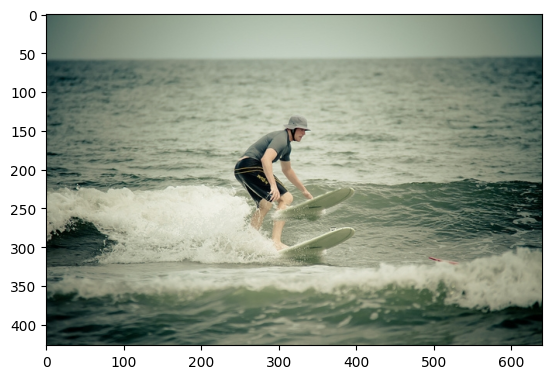

In [31]:
plt.imshow(x_train_fake_images[0][:,:,:])

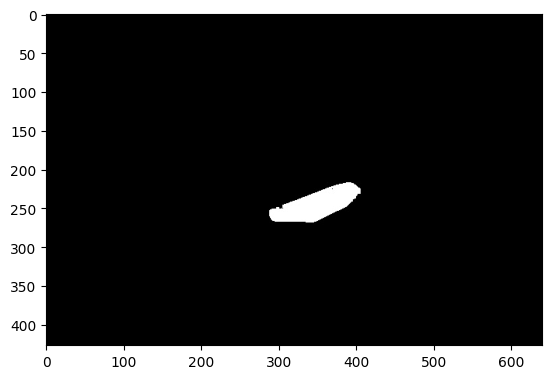

In [32]:
plt.imshow(x_train_masks[0], cmap='gray')

In [33]:
# Convert grayscale masks to binary
x_train_masks_binaries=[]

for grayscale in x_train_masks:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #binary_mask = cv2.merge([th]*3)
    x_train_masks_binaries.append(th)

In [34]:
len(x_train)

5126

In [35]:
len(x_train_masks_binaries)

2563

## 3.4. Prepare Test Set

In [36]:
x_test_images=[]

for x in x_test:
    try:
        img = Image.open(original_path+x)
        img_array = np.array(img)
        
    except FileNotFoundError:
        img = Image.open(fake_path+x)
        img_array = np.array(img)
        
    #img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x_test_images.append(img_array)

In [43]:
x_test_mask_names=[]
x_test_masks=[]

for ind, x in enumerate(x_test):
    if y_test[ind]==1:
        x_test_mask_names.append(x)
        
        img = Image.open(mask_path+x)
        img_array = np.array(img)
        #img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        x_test_masks.append(img_array)

In [44]:
x_test_fakes_names=[]
x_test_fake_images=[]

for ind, x in enumerate(x_test):
    if y_test[ind]==1:
        x_test_fakes_names.append(x)
        x_test_fake_images.append(x_test_images[ind])


In [45]:
x_test_original_names=[]
x_test_original_images=[]

for ind, x in enumerate(x_test):
    if y_test[ind]==0:
        x_test_original_names.append(x)
        x_test_original_images.append(x_test_images[ind])


In [46]:
# Convert grayscale masks to binary
x_test_masks_binaries=[]

for grayscale in x_test_masks:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #binary_mask = cv2.merge([th]*3)
    x_test_masks_binaries.append(th)

In [47]:
len(x_test)

1282

In [48]:
len(x_test_masks_binaries)

641

## 3.6. Feature Engineering on Train Set

In [49]:
mask_pixels = [np.count_nonzero(x_train_masks_binaries[i]) for i in range(len(x_train_masks_binaries))]

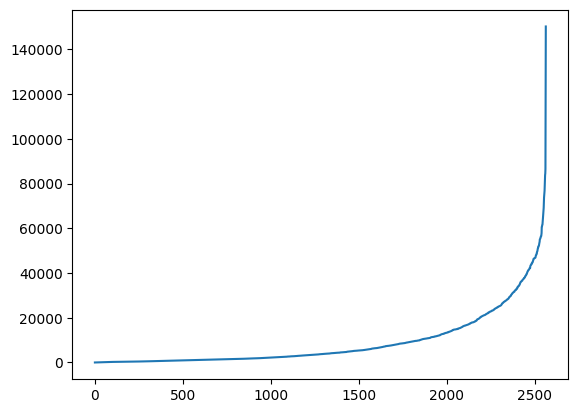

In [50]:
plt.plot(sorted(mask_pixels))

In [51]:
th=int(0.2*64*64)
th

819

In [52]:
x= sorted(mask_pixels)

We must capture information from every image. We use patch size of 32 * 32 and ensuring minimum 40% contribution from forged area and authentic area.
This ensures that more than 99% of masks are covered including discriminative boundary at the same time

### 3.6.1. Sampling The Fake Images

In [53]:
# Function that return:
# Number of pixels that have value 255 (mask pixels)

def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==255:
                i+=1
    return i

In [54]:
# Function that return:
# samples from each fake image

def sample_fake(img, mask):
    kernel_size=64
    stride=32
    
    samples=[]
    
    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):
            
            c_255=count_255(mask[y_start:y_start+kernel_size, x_start:x_start+kernel_size])
            
            if (c_255>th) and (kernel_size*kernel_size-c_255>th):
                samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])    
        
    return samples

In [57]:
sample=sample_fake(x_train_fake_images[0], x_train_masks[0])

In [58]:
len(sample)


5

In [59]:
x_train_fake_images[0].shape


(427, 640, 3)

In [60]:
x_train_masks[0].shape


(427, 640)

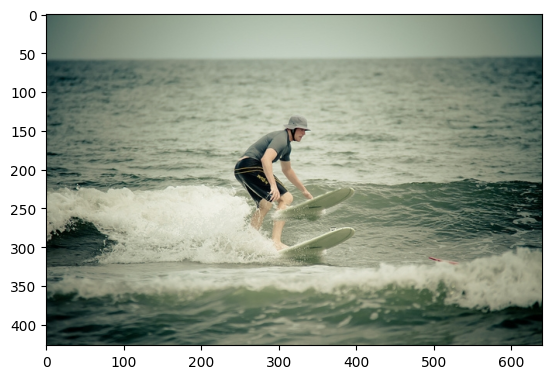

In [62]:
plt.imshow(x_train_fake_images[0])

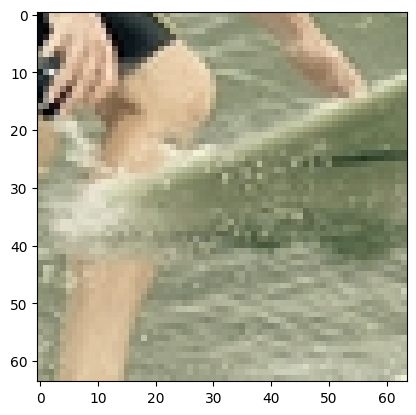

In [63]:
plt.imshow(sample[2])

In [64]:
len(x_train_fake_images)

2563

In [65]:
samples_fake=[]
i=0
for fake, mask in zip(x_train_fake_images, x_train_masks):
    image_samples=sample_fake(fake, mask)
    for sample in image_samples:
        samples_fake.append(sample)
        i+=1

In [66]:
samples_fake = np.stack(samples_fake)

In [67]:
fake_samples = samples_fake.shape[0]

In [68]:
fake_samples

20918

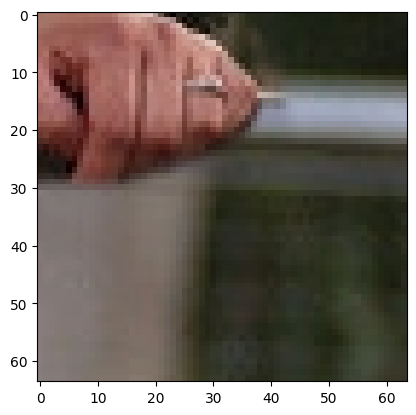

In [69]:
plt.imshow(samples_fake[245])

### 3.6.1. Sampling The Original Images

In [70]:
def sample_random(img, num_samples):
    kernel_size=64
    stride=32
    
    x_start=0
    y_start=0
    samples=[]
    
    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):
            
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))
    
    sampled=[]
    for i in indices:
        sampled.append(samples[i])
    
    return sampled

In [71]:
samples_per_original_image = int(np.ceil(fake_samples / len(x_train_original_images)))
samples_per_original_image

9

In [72]:
num_samples_original = int(samples_per_original_image*len(x_train_original_images))
num_samples_original

23067

In [73]:
samples_original=np.ndarray(shape=(num_samples_original, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for original_img in x_train_original_images:
    
    samples=sample_random(original_img, samples_per_original_image)
    for sample in samples:
        samples_original[i, :, :, :]=sample
        i+=1
print(i)

23067


In [74]:
original_samples = samples_original.shape[0]
original_samples

23067

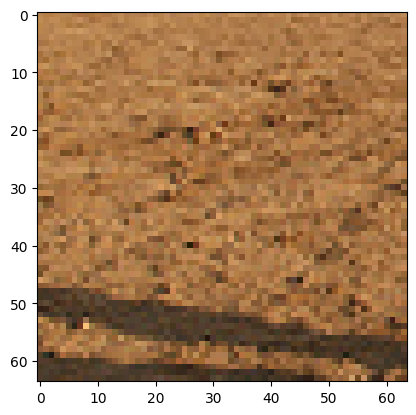

In [75]:
plt.imshow(samples_original[3255])

In [76]:
print(f'we have {fake_samples} fake samples each of shape 32 * 32 using binary masks')
print(f'we have {original_samples} original samples each of shape 32 * 32 using binary masks')

we have 20918 fake samples each of shape 32 * 32 using binary masks
we have 23067 original samples each of shape 32 * 32 using binary masks


In [77]:
train_labels = np.stack([0]*original_samples + [1]*fake_samples)

In [78]:
samples_original.shape

(23067, 64, 64, 3)

In [79]:
samples_fake.shape

(20918, 64, 64, 3)

In [80]:
train_labels.shape

(43985,)

In [81]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for binnary sampled images
train_data = np.concatenate((samples_original, samples_fake), axis=0)

In [82]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, stratify = train_labels)

## 3.6. Feature Engineering on Test Set

In [83]:
test_samples_fake=[]
i=0
for fake, mask in zip(x_test_fake_images, x_test_masks):
    image_samples=sample_fake(fake, mask)
    for sample in image_samples:
        test_samples_fake.append(sample)
        i+=1

In [84]:
test_samples_fake = np.stack(test_samples_fake)

In [85]:
test_fake_samples = test_samples_fake.shape[0]
test_fake_samples

5397

In [86]:
samples_per_original_image = int(np.ceil(test_fake_samples / len(x_test_original_images)))
samples_per_original_image

9

In [87]:
num_samples_original = int(samples_per_original_image*len(x_test_original_images))
num_samples_original

5769

In [88]:
test_samples_original=np.ndarray(shape=(num_samples_original, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for original_img in x_test_original_images:
    
    samples=sample_random(original_img, samples_per_original_image)
    for sample in samples:
        test_samples_original[i, :, :, :]=sample
        i+=1
print(i)

5769


In [89]:
test_original_samples = test_samples_original.shape[0]
test_original_samples

5769

In [90]:
print(f'we have {test_fake_samples} fake samples each of shape 64 * 64 using binary masks')
print(f'we have {test_original_samples} original samples each of shape 64 * 64 using binary masks')

we have 5397 fake samples each of shape 64 * 64 using binary masks
we have 5769 original samples each of shape 64 * 64 using binary masks


In [91]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for binnary sampled images
x_test_final = np.concatenate((test_samples_original, test_samples_fake), axis=0)

In [92]:
y_test_final = np.stack([0]*test_original_samples + [1]*test_fake_samples)

In [93]:
x_test_final.shape

(11166, 64, 64, 3)

In [94]:
y_test_final.shape

(11166,)

# 5. Training

## 5.1. Custom Model

In [126]:
image_shape=(64,64,3)

Custom_model = Sequential()

Custom_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))

Custom_model.add(Conv2D(64, (3, 3), activation='relu'))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))

Custom_model.add(Conv2D(128, (3, 3), activation='relu'))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))

Custom_model.add(Conv2D(256, (3, 3), activation='relu'))
Custom_model.add(MaxPooling2D(pool_size=(2, 2)))

Custom_model.add(Flatten())

Custom_model.add(Dense(512, activation='relu'))
Custom_model.add(Dropout(0.5))

Custom_model.add(Dropout(0.3))

Custom_model.add(Dense(1, activation='sigmoid'))

Custom_model.compile(loss='binary_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])

print(Custom_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

In [127]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

In [128]:
custom_history = Custom_model.fit(x_train, 
                                  y_train, 
                                  epochs=100, 
                                  batch_size=32, 
                                  validation_data=(x_valid, y_valid), 
                                  verbose=1,
                                  callbacks=[earlystop])


Epoch 1/100
1100/1100 [==============================] - 9s 8ms/step - loss: 0.7505 - accuracy: 0.5887 - val_loss: 0.5973 - val_accuracy: 0.6670
Epoch 2/100
1100/1100 [==============================] - 8s 7ms/step - loss: 0.5730 - accuracy: 0.6965 - val_loss: 0.4918 - val_accuracy: 0.7464
Epoch 3/100
1100/1100 [==============================] - 8s 7ms/step - loss: 0.4496 - accuracy: 0.7913 - val_loss: 0.3776 - val_accuracy: 0.8363
Epoch 4/100
1100/1100 [==============================] - 8s 7ms/step - loss: 0.4013 - accuracy: 0.8177 - val_loss: 0.3350 - val_accuracy: 0.8509
Epoch 5/100
1100/1100 [==============================] - 8s 7ms/step - loss: 0.3529 - accuracy: 0.8441 - val_loss: 0.3664 - val_accuracy: 0.8460
Epoch 6/100
1100/1100 [==============================] - 8s 7ms/step - loss: 0.3108 - accuracy: 0.8659 - val_loss: 0.2099 - val_accuracy: 0.9162
Epoch 7/100
1100/1100 [==============================] - 8s 7ms/step - loss: 0.2307 - accuracy: 0.9077 - val_loss: 0.1984 - val_ac

In [129]:
Custom_model.save('custom_model_V1.h5')

## 5.2. VGG 16 Model

In [130]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))
base_model.trainable = False ## Not trainable weights


print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [131]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(32, activation='relu')
dense_layer_2 = layers.Dense(16, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')

vgg_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

vgg_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(vgg_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 14,780,801
Trainable params: 66,113
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [132]:
vgg_history = vgg_model.fit(x_train, 
                                  y_train, 
                                  epochs=100, 
                                  batch_size=32, 
                                  validation_data=(x_valid, y_valid), 
                                  verbose=1,
                                  callbacks=[earlystop])

Epoch 1/100
1100/1100 [==============================] - 21s 18ms/step - loss: 0.6478 - accuracy: 0.6656 - val_loss: 0.5497 - val_accuracy: 0.7233
Epoch 2/100
1100/1100 [==============================] - 19s 17ms/step - loss: 0.5135 - accuracy: 0.7412 - val_loss: 0.5360 - val_accuracy: 0.7247
Epoch 3/100
1100/1100 [==============================] - 19s 18ms/step - loss: 0.4717 - accuracy: 0.7663 - val_loss: 0.5183 - val_accuracy: 0.7475
Epoch 4/100
1100/1100 [==============================] - 19s 18ms/step - loss: 0.4361 - accuracy: 0.7894 - val_loss: 0.5306 - val_accuracy: 0.7490
Epoch 5/100
1100/1100 [==============================] - 19s 17ms/step - loss: 0.3996 - accuracy: 0.8115 - val_loss: 0.5452 - val_accuracy: 0.7491
Epoch 6/100
1100/1100 [==============================] - 19s 17ms/step - loss: 0.3591 - accuracy: 0.8320 - val_loss: 0.5587 - val_accuracy: 0.7512
Epoch 7/100
1100/1100 [==============================] - 19s 17ms/step - loss: 0.3189 - accuracy: 0.8517 - val_loss: 0

In [133]:
vgg_model.save('vgg_model_V1.h5')

## 5.3. ResNet 50 Model

In [134]:
# load RaseNet50
model=ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

resnet_model=Sequential()
resnet_model.add(model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))

top_model.add(Dense(64, activation='relu'))

top_model.add(Dense(1, activation='sigmoid'))

resnet_model.add(top_model)


for layer in resnet_model.layers[0].layers[:171]:
    layer.trainable=False

resnet_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(resnet_model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 524417    
Total params: 24,112,129
Trainable params: 1,579,137
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [135]:
resnet_history = resnet_model.fit(x_train, 
                                  y_train, 
                                  epochs=100, 
                                  batch_size=32, 
                                  validation_data=(x_valid, y_valid), 
                                  verbose=1,
                                  callbacks=[earlystop])

Epoch 1/100
1100/1100 [==============================] - 25s 20ms/step - loss: 0.4676 - accuracy: 0.7802 - val_loss: 0.4287 - val_accuracy: 0.7989
Epoch 2/100
1100/1100 [==============================] - 20s 19ms/step - loss: 0.3169 - accuracy: 0.8604 - val_loss: 0.4294 - val_accuracy: 0.8113
Epoch 3/100
1100/1100 [==============================] - 20s 19ms/step - loss: 0.1995 - accuracy: 0.9160 - val_loss: 0.4660 - val_accuracy: 0.8161
Epoch 4/100
1100/1100 [==============================] - 20s 18ms/step - loss: 0.1153 - accuracy: 0.9539 - val_loss: 0.6105 - val_accuracy: 0.8240
Epoch 5/100
1100/1100 [==============================] - 21s 19ms/step - loss: 0.0699 - accuracy: 0.9737 - val_loss: 0.6427 - val_accuracy: 0.8255
Epoch 6/100
1100/1100 [==============================] - 21s 19ms/step - loss: 0.0540 - accuracy: 0.9804 - val_loss: 0.7369 - val_accuracy: 0.8212
Epoch 7/100
1100/1100 [==============================] - 22s 20ms/step - loss: 0.0406 - accuracy: 0.9856 - val_loss: 0

In [136]:
resnet_model.save('resnet_model_V1.h5')

# 6. Evaluation

In [137]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_PR_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
def plot_acc_curves(model_history):
    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.plot(model_history.history["accuracy"], label = "train accuracy", color = "red")
    plt.plot(model_history.history["val_accuracy"], label = "validation accuracy", color = "blue")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(model_history.history["loss"], label = "train loss", color = "red")
    plt.plot(model_history.history["val_loss"], label = "validation loss", color = "blue")

    plt.legend()
    plt.show()

## 6.1. Randoum Model

Log loss on Test Data using Random Model 0.8801399565107454
Accuracy on Test Data using Random Model 0.5033534159372514


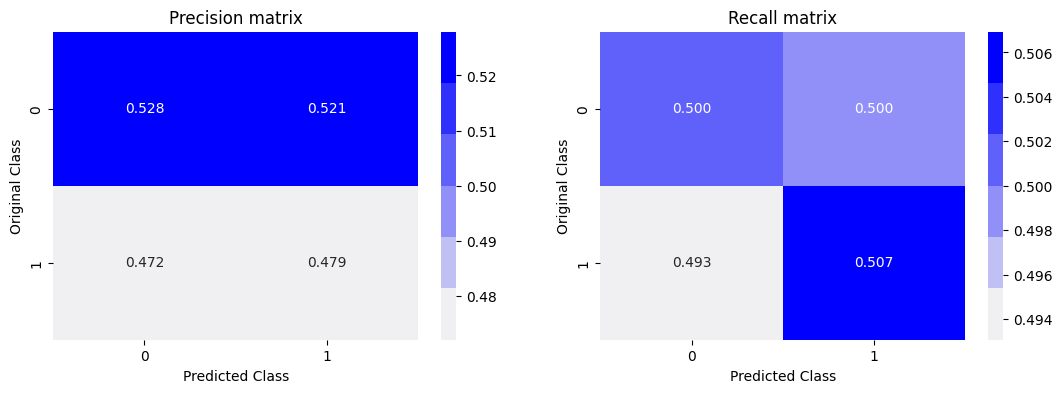

In [138]:
test_len=len(y_valid)
predicted_y_prob = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y_prob[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Test Data using Random Model",log_loss(y_valid, predicted_y_prob, eps=1e-15))
predicted_y =np.argmax(predicted_y_prob, axis=1)
print("Accuracy on Test Data using Random Model",accuracy_score(y_valid, predicted_y))

plot_PR_confusion_matrix(y_valid, predicted_y)

## 6.2. CNN architecture

### 6.2.1. Custom Model

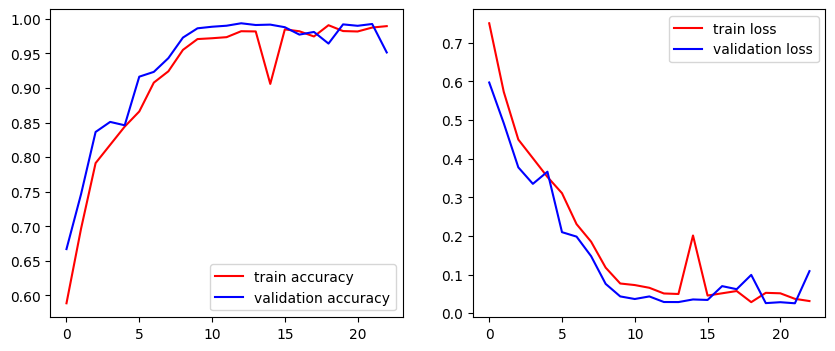

In [139]:
plot_acc_curves(custom_history)

In [140]:
predictions = Custom_model.predict(x_test_final, verbose = 1,workers=-1)

349/349 [==============================] - 0s 1ms/step


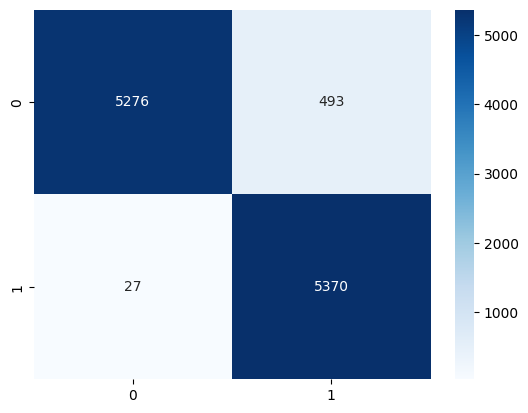

In [141]:
sns.heatmap(confusion_matrix(y_test_final, predictions.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

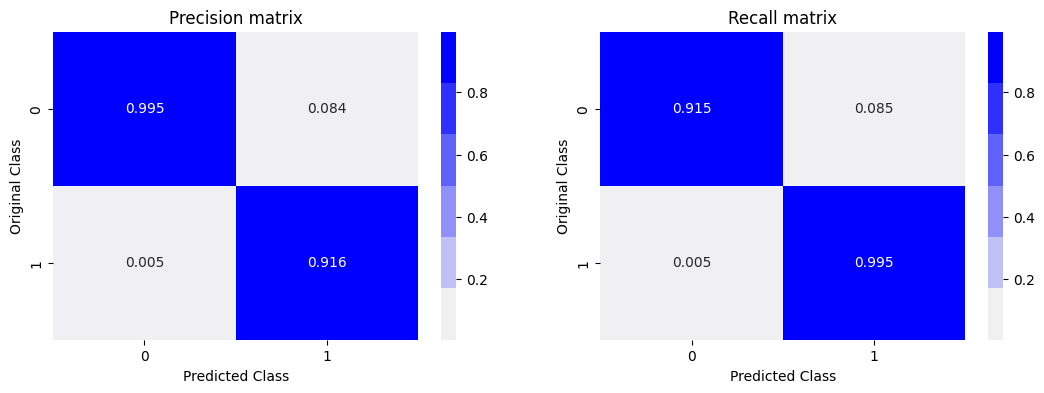

In [142]:
plot_PR_confusion_matrix(y_test_final, predictions.round())


In [143]:
print(classification_report(y_test_final,predictions.round()))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5769
           1       0.92      0.99      0.95      5397

    accuracy                           0.95     11166
   macro avg       0.96      0.95      0.95     11166
weighted avg       0.96      0.95      0.95     11166



### 6.2.2. VGG 16 Model

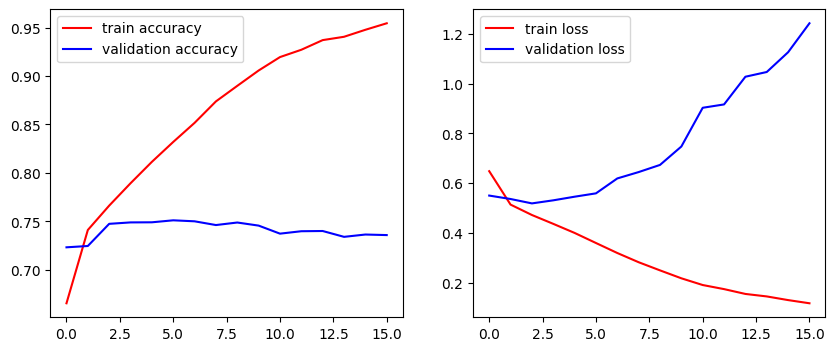

In [144]:
plot_acc_curves(vgg_history)

In [145]:
predictions = vgg_model.predict(x_test_final, verbose = 1,workers=-1)

349/349 [==============================] - 4s 12ms/step


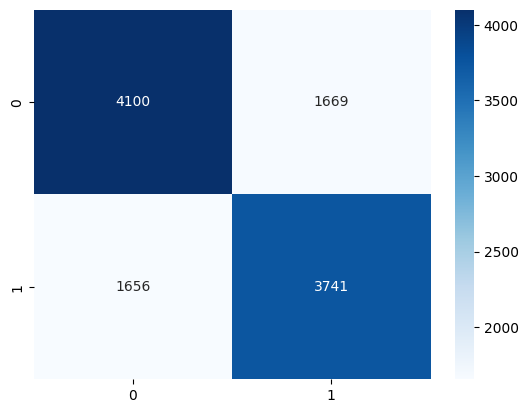

In [146]:
sns.heatmap(confusion_matrix(y_test_final, predictions.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

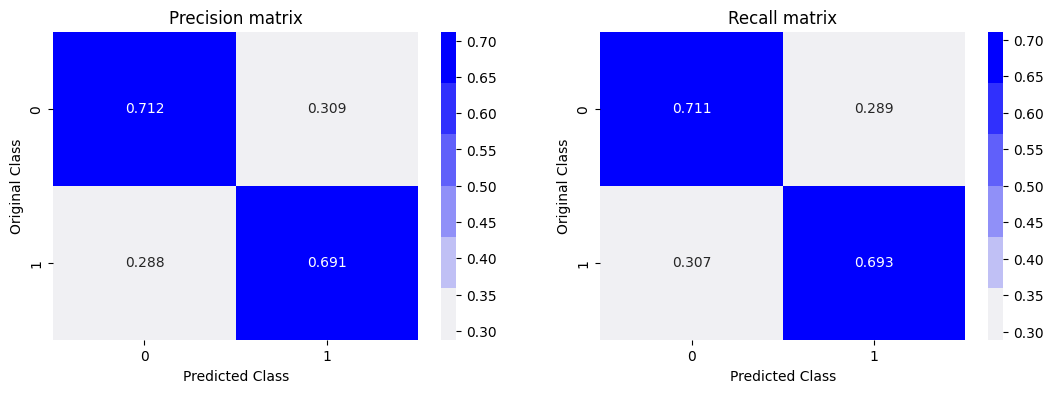

In [147]:
plot_PR_confusion_matrix(y_test_final, predictions.round())


In [148]:
print(classification_report(y_test_final,predictions.round()))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      5769
           1       0.69      0.69      0.69      5397

    accuracy                           0.70     11166
   macro avg       0.70      0.70      0.70     11166
weighted avg       0.70      0.70      0.70     11166



### 6.2.3. ResNet 50 Model

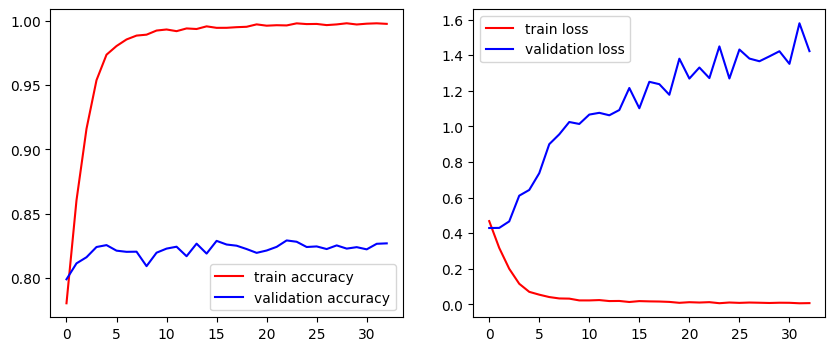

In [149]:
plot_acc_curves(resnet_history)

In [150]:
predictions = resnet_model.predict(x_test_final, verbose = 1,workers=-1)

349/349 [==============================] - 5s 11ms/step


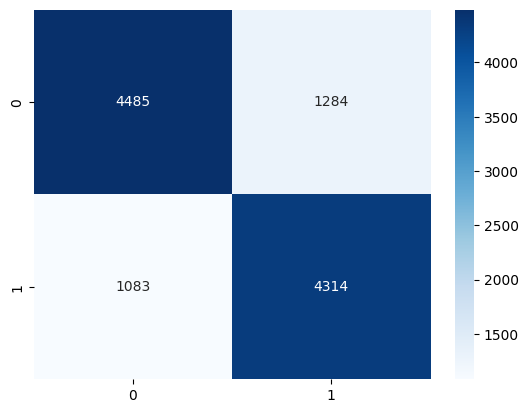

In [151]:
sns.heatmap(confusion_matrix(y_test_final, predictions.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

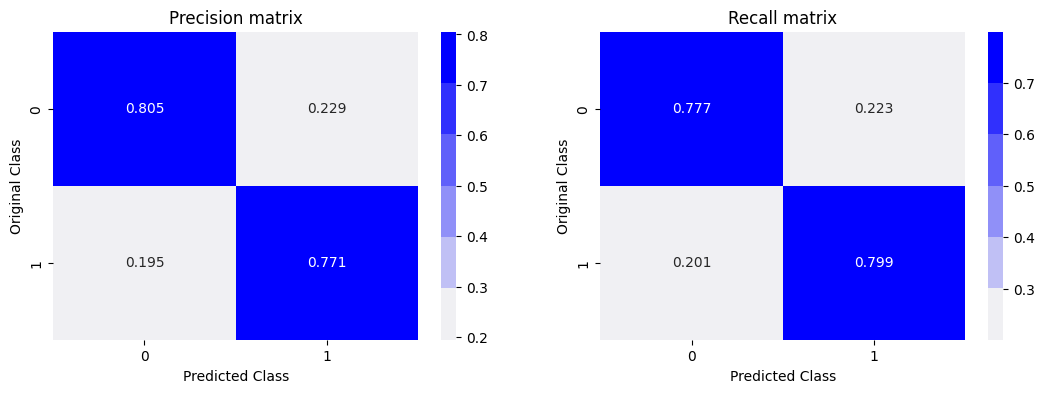

In [152]:
plot_PR_confusion_matrix(y_test_final, predictions.round())


In [153]:
print(classification_report(y_test_final,predictions.round()))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      5769
           1       0.77      0.80      0.78      5397

    accuracy                           0.79     11166
   macro avg       0.79      0.79      0.79     11166
weighted avg       0.79      0.79      0.79     11166



# 7. Prediction

In [383]:
def sample_predict(img):
    kernel_size=64
    stride=16
    
    samples=[]
    
    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):
            samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])    
        
    return samples

In [443]:
def predict(model,img):
    img = Image.open(img)
    img_array = np.array(img)
    img = cv2.resize(img_array, (512,512), interpolation = cv2.INTER_AREA)
    samples =  np.stack(sample_predict(img))
    predictions = model.predict(samples , verbose = 1,workers=-1)
    plt.imshow(img)
    if predictions.round().sum() > 180 :
        print("\nThis image is Forged!")
    else:
        print("\nThis image is real")

27/27 [==============================] - 0s 11ms/step

This image is Forged!


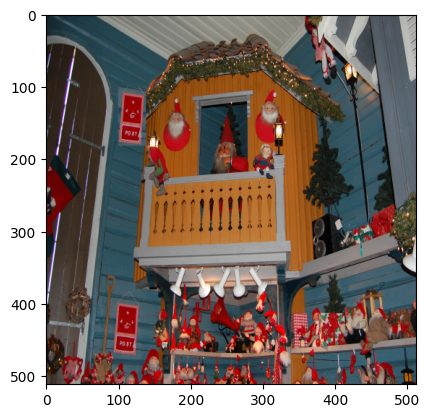

In [444]:
predict(Custom_model,"test_images\DSC_0013_01tamp1.jpg")

27/27 [==============================] - 0s 13ms/step

This image is Forged!


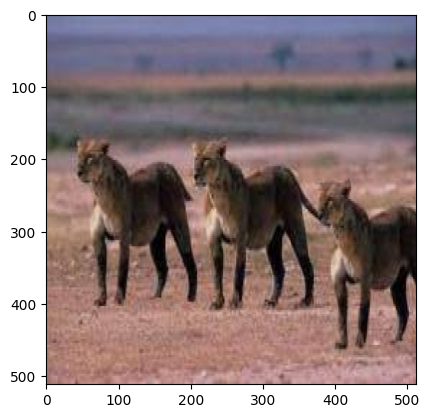

In [445]:
predict(Custom_model,"test_images\images.jpeg")

27/27 [==============================] - 0s 2ms/step

This image is Forged!


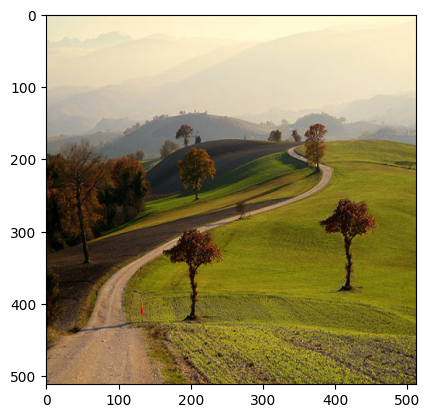

In [446]:
predict(Custom_model,"test_images\dyfPb.jpg")

27/27 [==============================] - 0s 5ms/step

This image is real


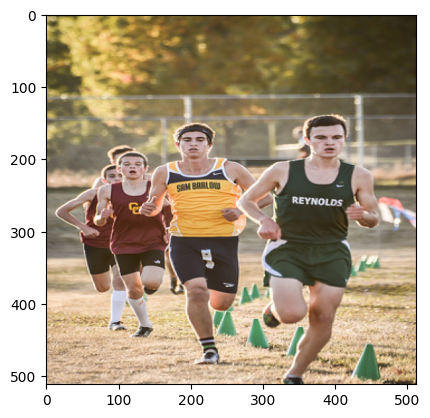

In [447]:
predict(Custom_model,"test_images\8243477528.jpg")

27/27 [==============================] - 0s 4ms/step

This image is real


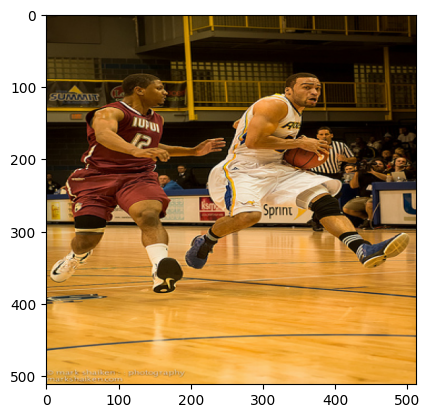

In [448]:
predict(Custom_model,"test_images\8245313425.jpg")

27/27 [==============================] - 0s 5ms/step

This image is real


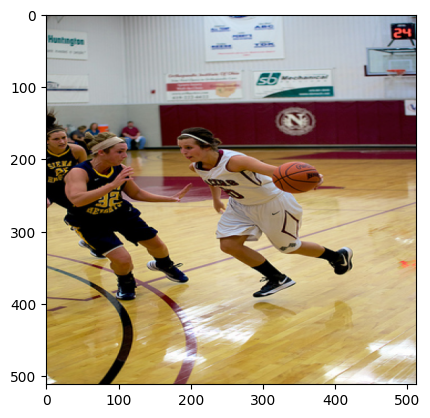

In [449]:
predict(Custom_model,"test_images\8245366095.jpg")

27/27 [==============================] - 0s 9ms/step

This image is Forged!


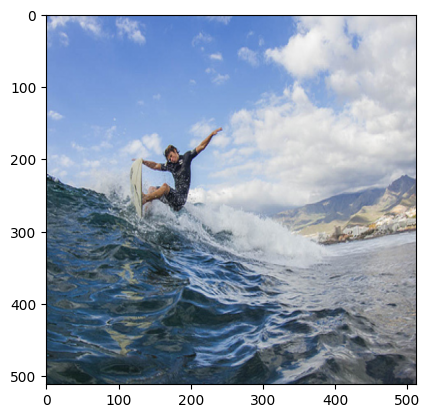

In [450]:
predict(Custom_model,"test_images\8247042603.jpg")

27/27 [==============================] - 0s 5ms/step

This image is real


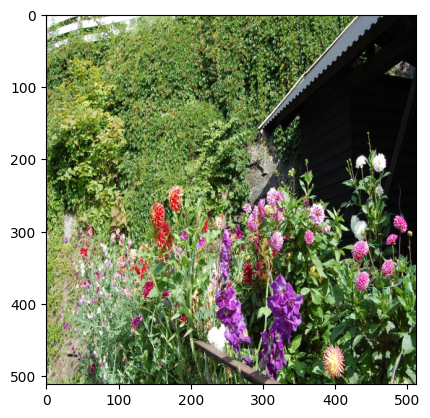

In [451]:
predict(Custom_model,"test_images\DSC_0100_01_scale.jpg")